# Training the REAL/FAKE classifier

In [119]:
%reload_ext autoreload
%autoreload 2

In [120]:
from fastai.core import *
from fastai.vision import *
from fastai.callbacks import *
from efficientnet_pytorch import EfficientNet
import albumentations as A
from kgl_deepfake.data_aug import *

## Data

In [102]:
path = Path('../data/cropped_faces/')

#### `SplitData` if using online selection model

dfdcs 5, 10, 35, and 40 are used in online selection, so if you're using these models, you should exclude face crops from these dfdcs.

In [103]:
_dfdcs, dfdcs = [5, 10, 35], [40,]

In [104]:
ant = pd.read_csv(path/'train.csv')
ant['dfdc'] = ant.directory.apply(lambda o: int(o.split('_')[-1]))
ovns = ant.set_index('dfdc').loc[_dfdcs + dfdcs].fname.unique()

`ovns` are the names of the videos which should be excluded.

In [105]:
train_items = get_image_files(path/'train')
len(train_items)

84328

In [106]:
train_items = [o for o in train_items if o.name.split('_')[0] not in ovns]
len(train_items)

81747

In [107]:
valid_items = get_image_files(path/'valid')

In [108]:
src = ImageList(train_items).split_none()
src.valid = ImageList(valid_items)

#### `SplitData` if not using online selection model

In [12]:
src = ImageList.from_folder(path).split_by_folder(train='train', valid='valid')

### Create `DataBunch`

Copy these data augs from *09_DataAugmentation.ipynb*

In [121]:
tfms = []
tfms += [alb_tfm2fastai(A.MotionBlur(blur_limit=9, p=.25), order=11)]
tfms += [alb_tfm2fastai(A.GaussNoise(var_limit=(15.0, 75.0), p=.25), order=12)]
tfms += [alb_tfm2fastai(A.JpegCompression(p=.25, quality_lower=30), order=13)]
tfms += [downscale(scale=0.5, p=.25)]

In [147]:
def get_data(bs,size):
    data = (src.label_from_re('([A-Z]+).jpg$')
           .transform(get_transforms(max_warp=0, max_zoom=1), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    return data

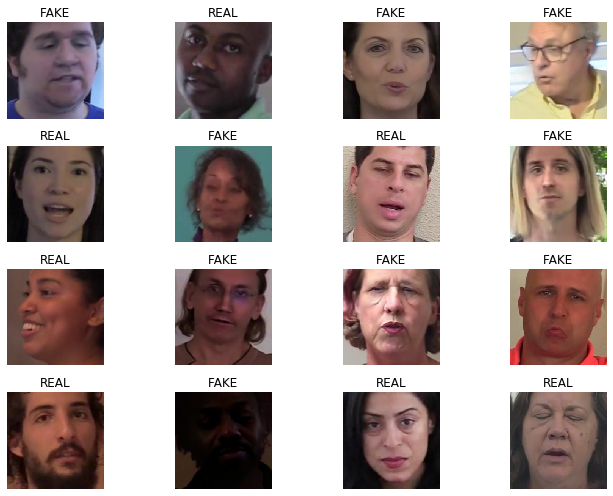

In [148]:
bs, sz = 32, 256
data = get_data(bs, sz)
data.show_batch(rows=4, figsize=(10,7))

## Resnet

In [ ]:
model = models.resnet18(num_classes=2)

In [ ]:
import copy

In [ ]:
fc = copy.deepcopy(model.fc)

In [ ]:
model.fc = nn.Identity()

In [ ]:
state_dict = torch.load('models/resnet_oselect_dfdc.pth')
model.load_state_dict(state_dict['model'])

<All keys matched successfully>

In [ ]:
model.fc = fc

In [ ]:
model.fc

Linear(in_features=512, out_features=2, bias=True)

In [ ]:
learn = Learner(data, model, path='./', metrics=[accuracy])

In [ ]:
learn.lr_find(start_lr=1e-11, end_lr=1e-7)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


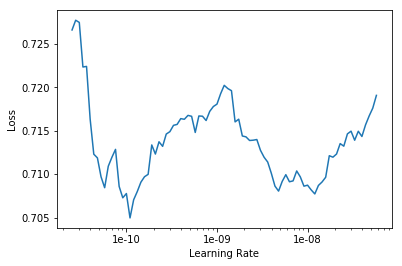

In [ ]:
learn.recorder.plot(skip_end=5)

In [ ]:
learn.fit_one_cycle(cyc_len=5, max_lr=1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.711658,0.714238,0.500000,00:43
1,0.710710,0.706583,0.522500,00:41
2,0.703991,0.704125,0.492500,00:41
3,0.703532,0.702864,0.472500,00:43
4,0.700790,0.702296,0.485000,00:44


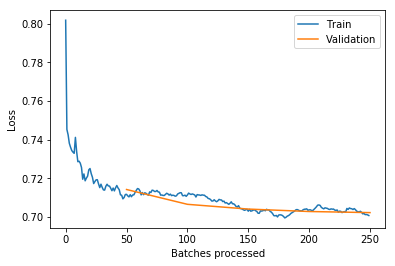

In [ ]:
learn.recorder.plot_losses()

## EfficientNetB0

### Transfer from Imagenet

In [65]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=data.train_dl.c)


Loaded pretrained weights for efficientnet-b0


In [66]:
learn = Learner(data, model, metrics=[accuracy])

In [67]:
#fm = flatten_model(model)
#learn.layer_groups = [nn.Sequential(*fm[:-3]), nn.Sequential(*fm[-3:])]

In [68]:
#learn.freeze_to(-1)

In [69]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


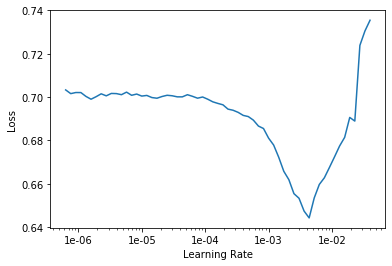

In [70]:
learn.recorder.plot(skip_end=15)

In [71]:
learn.fit_one_cycle(cyc_len=20, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.669000,0.705785,0.522500,00:12
1,0.546166,0.796264,0.572500,00:12
2,0.382067,0.801120,0.587500,00:12
3,0.297392,0.890991,0.655000,00:12
4,0.218553,1.139411,0.700000,00:12
5,0.220932,2.162415,0.622500,00:12
6,0.183045,1.362391,0.675000,00:12
7,0.143896,1.159336,0.665000,00:12
8,0.101916,1.913083,0.682500,00:12
9,0.089704,1.098780,0.685000,00:12


In [72]:
learn.save('effnetb0_classifier_ftimagenet')

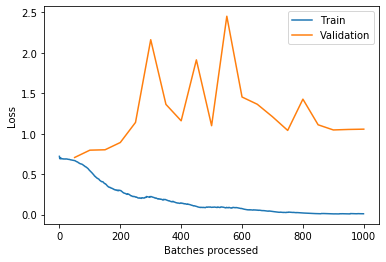

In [73]:
learn.recorder.plot_losses()

### Transfer from Online Selection

In [149]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=data.train_dl.c)


Loaded pretrained weights for efficientnet-b0


In [150]:
import copy

In [151]:
swish0 = copy.deepcopy(model._swish)
fc0 = copy.deepcopy(model._fc)
dropout0 = copy.deepcopy(model._dropout)

In [152]:
model._swish = nn.Identity()
model._fc = nn.Identity()
model._dropout = nn.Identity()

Specify which oneline selection model to fine-tune.

In [153]:
model_oselect = 'effnetb0_pairselect_margin1_39'

In [154]:
#state_dict = torch.load('models/effnetb0_oselect.pth')
state_dict = torch.load(f'models/pairselect_cycle0/{model_oselect}.pth')

In [131]:
model.load_state_dict(state_dict['model'])

<All keys matched successfully>

In [132]:
model._swish = swish0
model._fc = fc0
model._dropout = dropout0

In [139]:
learn = Learner(data, model, metrics=[accuracy])

In [140]:
# Discriminative learning.  DON"T WORK
#fm = flatten_model(model)
#learn.layer_groups = [nn.Sequential(*fm[:-3]), nn.Sequential(*fm[-3:])]

In [141]:
#learn.freeze_to(-1)

In [142]:
learn.load('ft_effnetb0_pairselect_margin1_39');

In [143]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


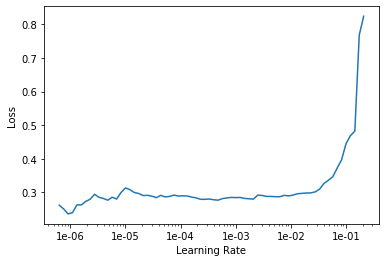

In [145]:
learn.recorder.plot(skip_end=0)

In [41]:
callbacks = [SaveModelCallback(learn, monitor='valid_loss', 
                               every='improvement', 
                               name=f'ft_{model_oselect}')]

In [146]:
learn.fit_one_cycle(cyc_len=5, max_lr=1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.284839,0.422904,0.802781,08:28
1,0.278899,0.420036,0.800206,08:28
2,0.265115,0.417006,0.801236,08:28
3,0.264488,0.417708,0.798661,08:29
4,0.251132,0.416298,0.799176,08:28


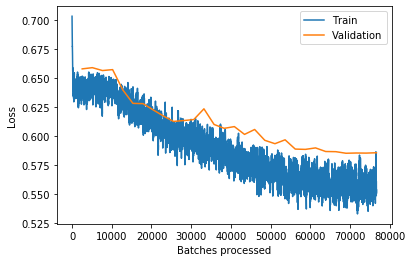

In [43]:
learn.recorder.plot_losses()

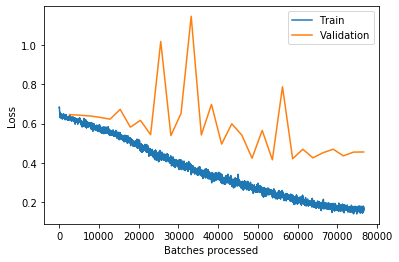

In [26]:
learn.recorder.plot_losses()

# -fin